## This is almost UNLIMITD-IX, with the NN as mean function

In [1]:
import numpy as np
import gpytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.func import functional_call, vmap, vjp, jvp, jacrev
device = 'cuda' if torch.cuda.device_count() > 0 else 'cpu'

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(42)
print(device)
print(np.__version__)
print(torch.__version__)
print(gpytorch.__version__)

cuda
1.24.3
2.0.0+cu117
1.11


## Tasks

In [2]:
import torch
import torch.nn as nn
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

class Sine_Task():
    """
    A sine wave data distribution object with interfaces designed for MAML.
    """
    def __init__(self, args, xmin, xmax):
        self.amplitude = args["amplitude"]
        self.phase = args["phase"]
        self.xmin = xmin
        self.xmax = xmax

    def true_function(self, x):
        """
        Compute the true function on the given x.
        """
        return self.amplitude * np.sin(self.phase + x)

    def sample_data(self, size=1, noise=0.0, sort=False, gpu=False):
        """
        Sample data from this task.

        returns:
            x: the feature vector of length size
            y: the target vector of length size
        """
        x = np.random.uniform(self.xmin, self.xmax, size)
        if(sort): x = np.sort(x)
        y = self.true_function(x)
        if(noise>0): y += np.random.normal(loc=0.0, scale=noise, size=y.shape)
        x = torch.tensor(x, dtype=torch.float).unsqueeze(1)
        y = torch.tensor(y, dtype=torch.float)
        if(gpu): return x.cuda(), y.cuda()
        else: return x, y
        
        
class Line_sine_Task():
    """
    A sine wave data distribution object with interfaces designed for MAML.
    """
    def __init__(self, args, xmin, xmax):
        self.slope = args["slope"]
        self.amplitude = args["amplitude"]
        self.phase = args["phase"]
        self.xmin = xmin
        self.xmax = xmax

    def true_function(self, x):
        """
        Compute the true function on the given x.
        """
        return self.amplitude * np.cos(self.phase + x) + self.slope * x

    def sample_data(self, size=1, noise=0.0, sort=False, gpu=False):
        """
        Sample data from this task.

        returns:
            x: the feature vector of length size
            y: the target vector of length size
        """
        x = np.random.uniform(self.xmin, self.xmax, size)
        if(sort): x = np.sort(x)
        y = self.true_function(x)
        if(noise>0): y += np.random.normal(loc=0.0, scale=noise, size=y.shape)
        x = torch.tensor(x, dtype=torch.float).unsqueeze(1)
        y = torch.tensor(y, dtype=torch.float)
        if(gpu): return x.cuda(), y.cuda()
        else: return x, y
    
class Line_Task():
    """
    A sine wave data distribution object with interfaces designed for MAML.
    """
    def __init__(self, args, xmin, xmax):
        self.slope = args["slope"]
        self.xmin = xmin
        self.xmax = xmax

    def true_function(self, x):
        """
        Compute the true function on the given x.
        """
        return x * self.slope

    def sample_data(self, size=1, noise=0.0, sort=False, gpu=False):
        """
        Sample data from this task.

        returns:
            x: the feature vector of length size
            y: the target vector of length size
        """
        x = np.random.uniform(self.xmin, self.xmax, size)
        if(sort): x = np.sort(x)
        y = self.true_function(x)
        if(noise>0): y += np.random.normal(loc=0.0, scale=noise, size=y.shape)
        x = torch.tensor(x, dtype=torch.float).unsqueeze(1)
        y = torch.tensor(y, dtype=torch.float)
        if(gpu): return x.cuda(), y.cuda()
        else: return x, y

In [3]:
class Multi_Task_Distribution():
    """
    The task distribution for sine regression tasks for MAML
    """

    def __init__(self, x_min, x_max, all_args_bounds, families=("sine", "line")):
        self.all_args_bounds = all_args_bounds
        self.x_min = x_min
        self.x_max = x_max
        self.families = families

    def sample_task(self):
        """
        Sample from the task distribution.

        returns:
            Sine_Task object or other at random from families
        """
        family = np.random.choice(self.families)
        args_bounds = self.all_args_bounds[family]
        args = {arg : np.random.uniform(bounds[0], bounds[1]) for (arg, bounds) in args_bounds.items()}
        
        if family=="sine":
            return ("sine", Sine_Task(args, self.x_min, self.x_max))
        elif family=="line":
            return ("line", Line_Task(args, self.x_min, self.x_max))
        elif family=="line_sine":
            return ("line_sine", Line_sine_Task(args, self.x_min, self.x_max))
        else:
            return None

## MODEL

In [4]:
class Feature(nn.Module):
    def __init__(self):
        super(Feature, self).__init__()
        self.layer1 = nn.Linear(1, 40)
        self.layer2 = nn.Linear(40,40)
        self.layer3 = nn.Linear(40,1)
        
    def forward(self, x):
        out = F.relu(self.layer1(x))
        out = F.relu(self.layer2(out))
        out = self.layer3(out)
        return out

In [5]:
class NTKernel(gpytorch.kernels.Kernel):
    def __init__(self, net, **kwargs):
        super(NTKernel, self).__init__(has_lengthscale=False, **kwargs)
        self.net = net
        
        N = sum(p.numel() for p in net.parameters()) # Number of params in the network
        self.N = N
        
        # Add N scaling parameters, initializing them as one
        mu = 0.0   # Mean of the underlying normal distribution
        sigma = 0.1  # Small standard deviation for values close to 1
        self.scaling_param = torch.distributions.LogNormal(mu, sigma).sample((N,))
        self.sp = self.scaling_param.view(1, self.N)
        
    def forward(self, x1, x2, diag=False, last_dim_is_batch=False, **params):
        jac1 = self.compute_jacobian(x1)
        jac2 = self.compute_jacobian(x2) if x1 is not x2 else jac1
        
        r1 = jac1*self.sp
        r2 = jac2*self.sp
        
        result = r1 @ r2.T
        
        if diag:
            return result.diag()
        return result
    
    def compute_jacobian(self, inputs):
        """
        Return the jacobian of a batch of inputs, thanks to the vmap functionality
        """
        self.zero_grad()
        params = {k: v for k, v in self.net.named_parameters()}
        def fnet_single(params, x):
            return functional_call(self.net, params, (x.unsqueeze(0),)).squeeze(0)
        
        jac = vmap(jacrev(fnet_single), (None, 0))(params, inputs)
        jac = jac.values()
        # jac1 of dimensions [Nb Layers, Nb input / Batch, dim(y), Nb param/layer left, Nb param/layer right]
        reshaped_tensors = [
            j.flatten(2)                # Flatten starting from the 3rd dimension to acount for weights and biases layers
                .permute(2, 0, 1)         # Permute to align dimensions correctly for reshaping
                .reshape(-1, j.shape[0] * j.shape[1])  # Reshape to (c, a*b) using dynamic sizing
            for j in jac
        ]
        return torch.cat(reshaped_tensors, dim=0).T

In [6]:
class CosSimNTKernel(gpytorch.kernels.Kernel):
    def __init__(self, net, **kwargs):
        super(CosSimNTKernel, self).__init__(**kwargs)
        self.net = net
        
        self.alpha = nn.Parameter(torch.ones(1))
        
        N = sum(p.numel() for p in net.parameters()) # Number of params in the network
        self.N = N
        
        # Add N scaling parameters, initializing them as one
        self.scaling_param = nn.Parameter(torch.ones(N)).cuda()
        self.sp = self.scaling_param.view(1, self.N).cuda()

    def forward(self, x1, x2, diag=False, **params):
        r1T = (self.compute_jacobian(x1) * self.sp).T
        r1T_norm = r1T.norm(dim=0, keepdim=True)
        r1T_normalized = r1T/r1T_norm
        
        r2T = (self.compute_jacobian(x2) * self.sp).T if x1 is not x2 else jac1T
        r2T_norm = r2T.norm(dim=0, keepdim=True)
        r2T_normalized = r2T/r2T_norm
        
        result = self.alpha * r1T_normalized.T@r2T_normalized
        
        if diag:
            return result.diag()
        return result
    
    def compute_jacobian(self, inputs):
        """
        Return the jacobian of a batch of inputs, thanks to the vmap functionality
        """
        self.zero_grad()
        params = {k: v for k, v in self.net.named_parameters()}
        def fnet_single(params, x):
            return functional_call(self.net, params, (x.unsqueeze(0),)).squeeze(0)
        
        jac = vmap(jacrev(fnet_single), (None, 0))(params, inputs)
        jac = jac.values()
        # jac1 of dimensions [Nb Layers, Nb input / Batch, dim(y), Nb param/layer left, Nb param/layer right]
        reshaped_tensors = [
            j.flatten(2)                # Flatten starting from the 3rd dimension to acount for weights and biases layers
                .permute(2, 0, 1)         # Permute to align dimensions correctly for reshaping
                .reshape(-1, j.shape[0] * j.shape[1])  # Reshape to (c, a*b) using dynamic sizing
            for j in jac
        ]
        return torch.cat(reshaped_tensors, dim=0).T

In [7]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, net):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = NTKernel(net)
        #self.covar_module = CosSimNTKernel(net)
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5))
        #self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=4, ard_num_dims=40)
        #self.feature_extractor = feature_extractor
        
    def forward(self, x):
        #z = self.feature_extractor(x)
        #z_normalized = z - z.min(0)[0]
        #z_normalized = 2 * (z_normalized / z_normalized.max(0)[0]) - 1
        #x_normalized = x - x.min(0)[0]
        #x_normalized = 2 * (x_normalized / x_normalized.max(0)[0]) - 1
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [8]:
n_shot_train = 10
n_shot_test = 5
train_range=(-5.0, 5.0)
test_range=(-5.0, 5.0) # This must be (-5, +10) for the out-of-range condition
criterion = nn.MSELoss()

# family = "line_sine"
# args_line_sine = {"amplitude_min":0.1, "amplitude_max":5.0, 
#         "phase_min":0.0, "phase_max":np.pi,
#         "slope_min":0.0, "slope_max":3.0}

families = ("sine", "line")
sine_args_bounds = {"amplitude":(.1, 5), 
        "phase":(0, np.pi)}
line_args_bounds = {"slope":(.2, 2)}
all_args_bounds = {"sine":sine_args_bounds,
                   "line":line_args_bounds}

tasks = Multi_Task_Distribution(x_min=train_range[0], x_max=train_range[1], 
                      all_args_bounds=all_args_bounds, families=families)

In [9]:
net       = Feature()
likelihood = gpytorch.likelihoods.GaussianLikelihood()
# likelihood.noise_covar.register_constraint("raw_noise", gpytorch.constraints.GreaterThan(1e-4))
# likelihood.noise = 1e-4
dummy_inputs = torch.zeros([n_shot_train,1])
dummy_labels = torch.zeros([n_shot_train])


gp1 = ExactGPModel(dummy_inputs, dummy_labels, likelihood, net)
mll1 = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp1)

gp2 = ExactGPModel(dummy_inputs, dummy_labels, likelihood, net)
mll2 = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp2)

optimizer = torch.optim.Adam([{'params': gp1.covar_module.scaling_param, 'lr': 1e-3},
                             {'params': gp2.covar_module.scaling_param, 'lr': 1e-3},
                             {'params': net.parameters(), 'lr': 1e-3}])

## TRAIN

In [10]:
np.random.seed(1)
torch.manual_seed(1)

In [11]:
import time

likelihood.train()
gp1.train()
gp2.train()
net.train()

tot_iterations=5000

t = time.time_ns()

for epoch in range(tot_iterations):
    # gp.likelihood.noise = 1e-2
    optimizer.zero_grad()
    loss=0
    for inner_epoch in range(1):
        task = tasks.sample_task()
        family = task[0]
        inputs, labels = task[1].sample_data(n_shot_train, noise=0.1)

        with gpytorch.settings.cholesky_jitter(float_value=1e-3, double_value=1e-4, half_value=None):

            gp1.set_train_data(inputs=inputs, targets=labels - net(inputs).reshape(-1))  
            predictions1 = gp1(inputs)
            loss1 = -mll1(predictions1, gp1.train_targets)

            gp2.set_train_data(inputs=inputs, targets=labels - net(inputs).reshape(-1))  
            predictions2 = gp2(inputs)
            loss2 = -mll2(predictions2, gp2.train_targets)
            if family == "line":
                loss += -torch.logsumexp(torch.stack([-loss1*np.sqrt(5001)/np.sqrt(epoch+1), -loss2]), dim=0)
            
            if family == "sine":
                loss += -torch.logsumexp(torch.stack([-loss1, -loss2*np.sqrt(5001)/np.sqrt(epoch+1)]), dim=0)
        
    loss.backward()
    optimizer.step()
    mse1 = criterion(predictions1.mean, labels)
    #---- print some stuff ----
    if(epoch%100==0):
        print('[%d] - Loss: %.3f  MSE : %.3f  lengthscale: %.3f   noise: %.3f' % (
            epoch, loss.item(), mse1.item(),
            0.0, #gp.covar_module.base_kernel.lengthscale.item(),
            gp1.likelihood.noise.item()
        ))
        
print(f"Total time : {(time.time_ns()-t)/1e9} s")

[0] - Loss: 1.664  MSE : 41.025  lengthscale: 0.000   noise: 0.693
[100] - Loss: 1.563  MSE : 21.555  lengthscale: 0.000   noise: 0.693
[200] - Loss: 1.911  MSE : 3.436  lengthscale: 0.000   noise: 0.693
[300] - Loss: 1.533  MSE : 0.998  lengthscale: 0.000   noise: 0.693
[400] - Loss: 1.620  MSE : 20.125  lengthscale: 0.000   noise: 0.693
[500] - Loss: 1.346  MSE : 1.873  lengthscale: 0.000   noise: 0.693
[600] - Loss: 1.344  MSE : 5.217  lengthscale: 0.000   noise: 0.693
[700] - Loss: 1.330  MSE : 0.445  lengthscale: 0.000   noise: 0.693
[800] - Loss: 1.340  MSE : 0.407  lengthscale: 0.000   noise: 0.693
[900] - Loss: 1.281  MSE : 0.403  lengthscale: 0.000   noise: 0.693
[1000] - Loss: 1.281  MSE : 6.535  lengthscale: 0.000   noise: 0.693
[1100] - Loss: 1.294  MSE : 11.335  lengthscale: 0.000   noise: 0.693
[1200] - Loss: 1.196  MSE : 0.418  lengthscale: 0.000   noise: 0.693
[1300] - Loss: 2.220  MSE : 14.722  lengthscale: 0.000   noise: 0.693
[1400] - Loss: 1.275  MSE : 2.205  length

## Test phase

In [12]:
np.random.seed(2)
torch.manual_seed(2)

In [13]:
# family = "line_sine"
# args_line_sine = {"amplitude_min":0.1, "amplitude_max":5.0, 
#         "phase_min":0.0, "phase_max":np.pi,
#         "slope_min":0.0, "slope_max":3.0}

class Sine_Task():
    """
    A sine wave data distribution object with interfaces designed for MAML.
    """
    def __init__(self, amplitude, phase, xmin, xmax):
        self.amplitude = amplitude
        self.phase = phase
        self.xmin = xmin
        self.xmax = xmax

    def true_function(self, x):
        """
        Compute the true function on the given x.
        """
        return self.amplitude * np.sin(self.phase + x)

    def sample_data(self, size=1, noise=0.0, sort=False, gpu=False):
        """
        Sample data from this task.

        returns:
            x: the feature vector of length size
            y: the target vector of length size
        """
        x = np.random.uniform(self.xmin, self.xmax, size)
        if(sort): x = np.sort(x)
        y = self.true_function(x)
        if(noise>0): y += np.random.normal(loc=0.0, scale=noise, size=y.shape)
        x = torch.tensor(x, dtype=torch.float).unsqueeze(1)
        y = torch.tensor(y, dtype=torch.float)
        if(gpu): return x.cuda(), y.cuda()
        else: return x, y
 
class Task_Distribution():
    """
    The task distribution for sine regression tasks for MAML
    """

    def __init__(self, x_min, x_max, args, family="sine"):
        self.args = args
        self.x_min = x_min
        self.x_max = x_max
        self.family = family

    def sample_task(self):
        """
        Sample from the task distribution.

        returns:
            Sine_Task object
        """
        if(self.family=="sine"):
            amplitude = np.random.uniform(self.args["amplitude_min"], self.args["amplitude_max"])
            phase = np.random.uniform(self.args["phase_min"], self.args["phase_max"])
            return Sine_Task(amplitude, phase, self.x_min, self.x_max)
        elif(self.family=="line_sine"):
            amplitude = np.random.uniform(self.args["amplitude_min"], self.args["amplitude_max"])
            phase = np.random.uniform(self.args["phase_min"], self.args["phase_max"])
            slope = np.random.uniform(self.args["slope_min"], self.args["slope_max"])
            return Line_sine_Task(slope, amplitude, phase, self.x_min, self.x_max)
        else:
            return None
        
family = "sine"
args_line_sine = {"amplitude_min":0.1, "amplitude_max":5.0, 
        "phase_min":0.0, "phase_max":np.pi}

tasks_test = Task_Distribution(x_min=train_range[0], x_max=train_range[1], 
                      args=args_line_sine, family=family)

In [14]:
print("Test, please wait...")

likelihood.eval()    
net.eval()
trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Trainable parameters : {trainable_params}")
not_trainable_params = sum(p.numel() for p in net.parameters() if not p.requires_grad)
print(f"Non Trainable parameters : {not_trainable_params}")

tot_iterations=500
mse_list = list()
for epoch in range(tot_iterations):
    sample_task = tasks_test.sample_task()
    sample_size = 200
    x_all, y_all = sample_task.sample_data(sample_size, noise=0.1, sort=True)
    
    indices = np.arange(sample_size)
    support_indices_choice = np.arange(sample_size)  # Indices where the support data can be
    # support_indices_choice = np.arange(sample_size//2)  #If only half the indices can be used for support set
    
    np.random.shuffle(support_indices_choice)
    support_indices = np.sort(support_indices_choice[0:n_shot_test])

    query_indices = np.sort(np.setdiff1d(indices, support_indices))
    x_support = x_all[support_indices]
    y_support = y_all[support_indices]
    x_query = x_all[query_indices]
    y_query = y_all[query_indices]
    
    #Feed the support set
    gp1.train()
    gp1.set_train_data(inputs=x_support, targets=y_support - net(x_support).reshape(-1), strict=False)  
    gp1.eval()

    #Evaluation on query set
    mean = likelihood(gp1(x_query)).mean + net(x_query).reshape(-1)

    mse = criterion(mean, y_query)
    mse_list.append(mse.item())

print("-------------------")
print("Average MSE: " + str(np.mean(mse_list)) + " +- " + str(np.std(mse_list)))
print("-------------------")

Test, please wait...
Trainable parameters : 1761
Non Trainable parameters : 0
-------------------
Average MSE: 2.206306742634624 +- 2.952663229775881
-------------------


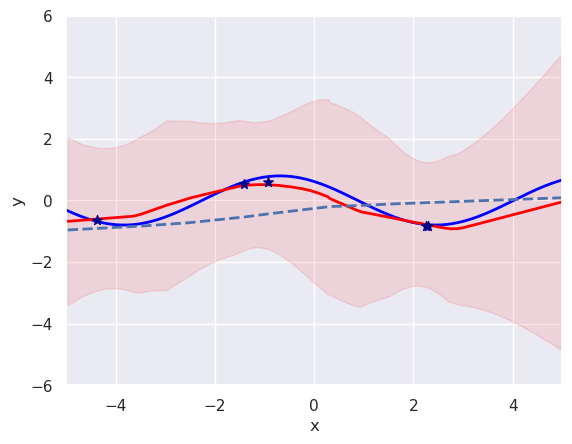

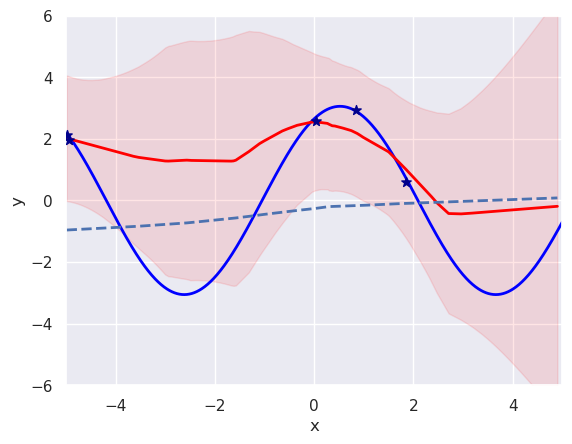

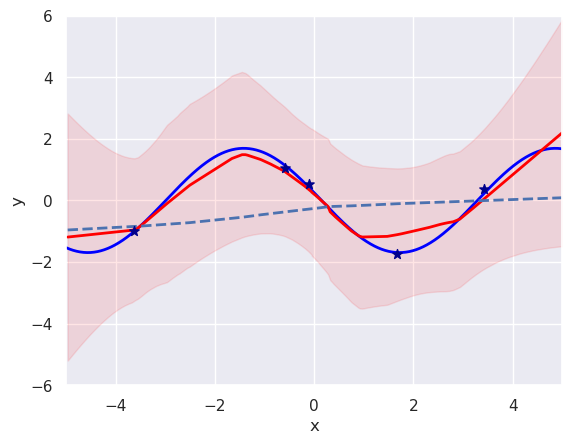

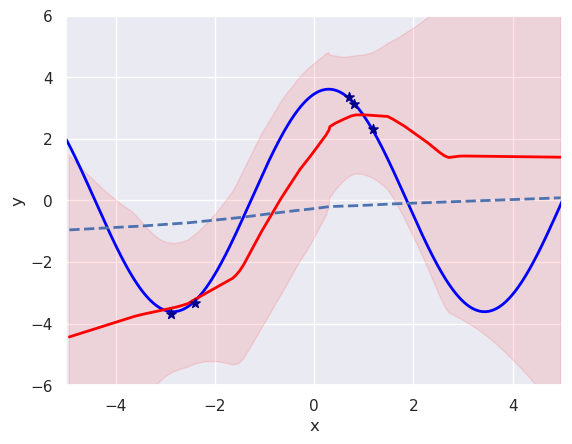

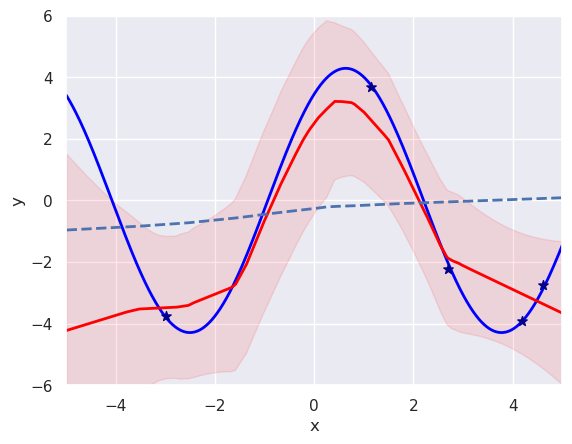

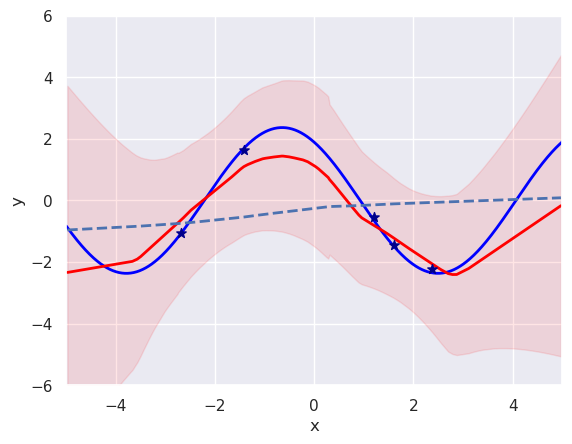

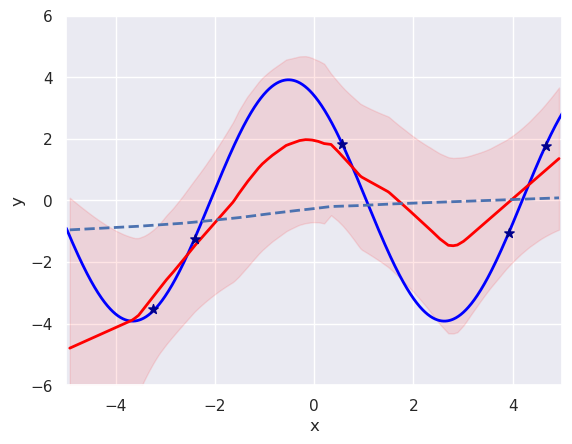

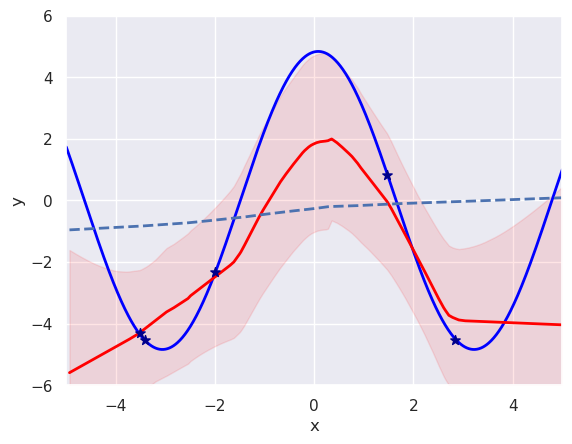

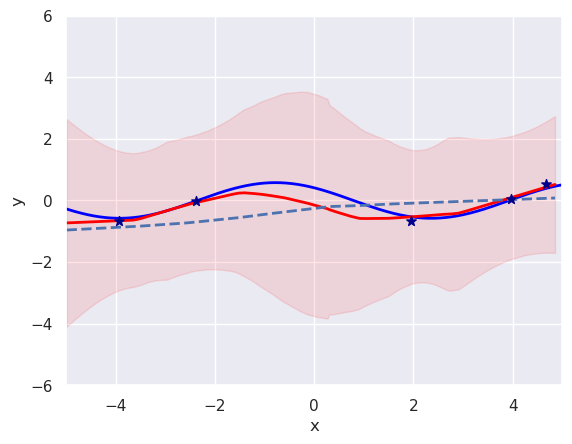

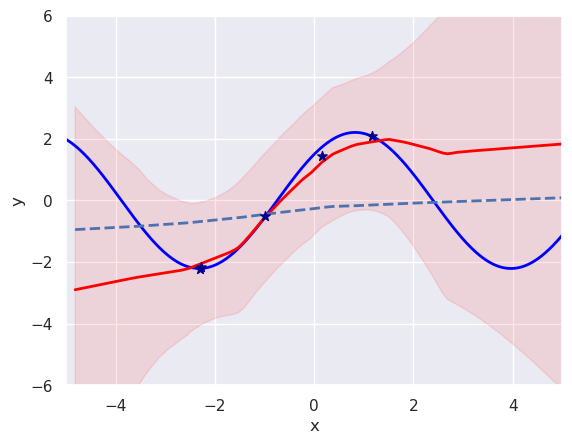

In [15]:
sample_size=200
for i in range(10):
    sample_task = tasks_test.sample_task()
    x_all, y_all = sample_task.sample_data(sample_size, noise=0.1, sort=True)
    indices = np.arange(sample_size)
    support_indices_choice = np.arange(sample_size)  # Indices where the support data can be
    # support_indices_choice = np.arange(sample_size//2)  #If only half the indices can be used for support set
    
    np.random.shuffle(support_indices_choice)
    support_indices = np.sort(support_indices_choice[0:n_shot_test])
    #print(support_indices)

    query_indices = np.sort(np.setdiff1d(indices, support_indices))
    x_support = x_all[support_indices]
    y_support = y_all[support_indices]
    x_query = x_all[query_indices]
    y_query = y_all[query_indices]

    gp1.train()
    gp1.set_train_data(inputs=x_support, targets=y_support - net(x_support).reshape(-1), strict=False)  
    gp1.eval()
            
    #Evaluation on all data
    mean = likelihood(gp1(x_all)).mean + net(x_all).reshape(-1)
    lower, upper = likelihood(gp1(x_all)).confidence_region() #2 standard deviations above and below the mean
    lower += net(x_all).reshape(-1)
    upper += net(x_all).reshape(-1)    
    
    #Plot
    fig, ax = plt.subplots()
    #true-curve
    true_curve = np.linspace(train_range[0], train_range[1], 1000)
    true_curve = [sample_task.true_function(x) for x in true_curve]
    ax.plot(np.linspace(train_range[0], train_range[1], 1000), true_curve, color='blue', linewidth=2.0)
    if(train_range[1]<test_range[1]):
        dotted_curve = np.linspace(train_range[1], test_range[1], 1000)
        dotted_curve = [sample_task.true_function(x) for x in dotted_curve]
        ax.plot(np.linspace(train_range[1], test_range[1], 1000), dotted_curve, color='blue', linestyle="--", linewidth=2.0)
    #query points (ground-truth)
    #ax.scatter(x_query, y_query, color='blue')
    #query points (predicted)

    ax.plot(np.squeeze(x_all), mean.detach().numpy(), color='red', linewidth=2.0)
    ax.plot(np.squeeze(x_all), net(x_all).reshape(-1).detach().numpy(), "b--", linewidth=2.0)
    ax.fill_between(np.squeeze(x_all),
                    lower.detach().numpy(), upper.detach().numpy(),
                    alpha=.1, color='red')
    #support points
    ax.scatter(x_support.detach(), y_support.detach(), color='darkblue', marker='*', s=50, zorder=10)
                    
    #all points
    #ax.scatter(x_all.numpy(), y_all.numpy())
    #plt.show()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.ylim(-6.0, 6.0)
    plt.xlim(test_range[0], test_range[1])
    plt.savefig('plot_oursIX_multi_' + str(i) + '.png', dpi=300)

In [16]:
print(f"Ten first elements of Sigma : {gp2.covar_module.sp[0, :10].detach().numpy()}")
print(f"Ten last elements of Sigma : {gp2.covar_module.sp[0, -10:].detach().numpy()}")
Sigma = gp2.covar_module.sp[0,:].detach().numpy()
print(f"Norm of Sigma : {np.linalg.norm(Sigma, 2)}")
print(f"Norm of Sigma normalized by number of params : {np.linalg.norm(Sigma, 2)/Sigma.shape[0]}")
print(f"Max of Sigma values : {max(Sigma)}")

Ten first elements of Sigma : [0.76529396 1.0187013  0.87699574 0.9253757  0.9905825  0.8894432
 1.0518528  1.0384027  0.8894828  1.0259274 ]
Ten last elements of Sigma : [0.8576044  0.96278614 0.93796074 1.0019155  0.9309967  0.93215793
 1.080045   1.0207444  1.0578333  0.91009563]
Norm of Sigma : 42.36241149902344
Norm of Sigma normalized by number of params : 0.024055883872244995
Max of Sigma values : 1.3965978622436523


In [17]:
def inverse_transformation(transformed_tensor, original_shapes, shrinking_factor):
    # Step 1: Transpose the tensor back
    transposed_tensor = transformed_tensor.T
    
    # Convert to PyTorch tensor if it's a NumPy array
    if isinstance(transposed_tensor, np.ndarray):
        transposed_tensor = torch.from_numpy(transposed_tensor)
    
    # Step 2: Calculate the correct split sizes
    split_sizes = [torch.prod(torch.tensor(shape)).item() for shape in original_shapes]
    
    # Determine the dimension to split along
    split_dim = 1 if transposed_tensor.dim() > 1 else 0
    
    # Step 3: Split the tensor back into the original number of reshaped tensors
    split_tensors = torch.split(transposed_tensor, split_sizes, dim=split_dim)
    
    original_tensors = []
    
    for split_tensor, shape in zip(split_tensors, original_shapes):
        # Step 4: Reshape back to the original flattened shape
        reshaped_tensor = split_tensor.reshape(-1, *shape[:2]) if len(shape) > 1 else split_tensor.reshape(shape[0], -1)
        
        # Step 5: Permute dimensions back
        if len(shape) > 2:  # Only permute if the original tensor had more than 2 dimensions
            permuted_tensor = reshaped_tensor.permute(1, 2, 0)
        else:
            permuted_tensor = reshaped_tensor
        
        # Step 6: Reshape back to the original shape
        original_tensor = shrinking_factor * permuted_tensor.reshape(shape)
        
        original_tensors.append(original_tensor)
    
    
    return original_tensors

def name_tensor(named_params, inverse_transformed):
    named_tensor = {name : sigma for name,sigma in zip(named_params.keys(), inverse_transformed)}
    return named_tensor

named_params = dict(gp2.covar_module.net.named_parameters())
shape_list = list([param.shape for param in named_params.values()])
print(shape_list)

Sigma_adapted_lr = inverse_transformation(Sigma.T, shape_list, shrinking_factor=0.1)
print(Sigma_adapted_lr)
Sigma_adapted_lr = name_tensor(named_params, Sigma_adapted_lr)
print(Sigma_adapted_lr)

[torch.Size([40, 1]), torch.Size([40]), torch.Size([40, 40]), torch.Size([40]), torch.Size([1, 40]), torch.Size([1])]
[tensor([[0.0765],
        [0.1019],
        [0.0877],
        [0.0925],
        [0.0991],
        [0.0889],
        [0.1052],
        [0.1038],
        [0.0889],
        [0.1026],
        [0.1046],
        [0.0925],
        [0.0773],
        [0.1143],
        [0.1086],
        [0.1019],
        [0.1014],
        [0.1136],
        [0.1044],
        [0.1012],
        [0.1057],
        [0.1031],
        [0.1054],
        [0.1156],
        [0.0982],
        [0.0984],
        [0.1052],
        [0.1128],
        [0.1056],
        [0.0950],
        [0.0833],
        [0.0907],
        [0.0987],
        [0.1063],
        [0.0758],
        [0.1045],
        [0.1013],
        [0.1164],
        [0.1025],
        [0.0911]]), tensor([0.0946, 0.0962, 0.1109, 0.1017, 0.0943, 0.0999, 0.1026, 0.1013, 0.0949,
        0.0959, 0.1008, 0.1174, 0.1135, 0.1019, 0.1066, 0.1054, 0.1016, 0.1064,

# Fine tuning using $\Sigma$-adapted lr

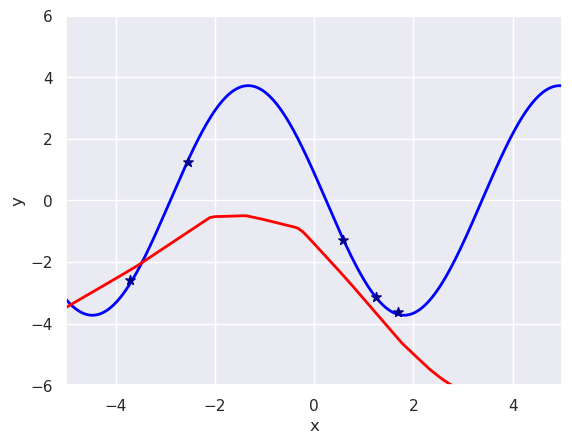

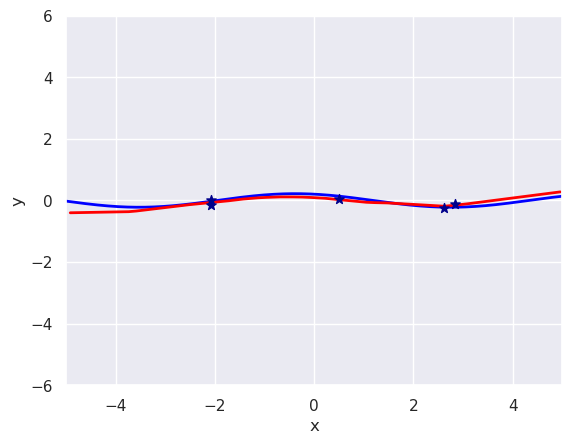

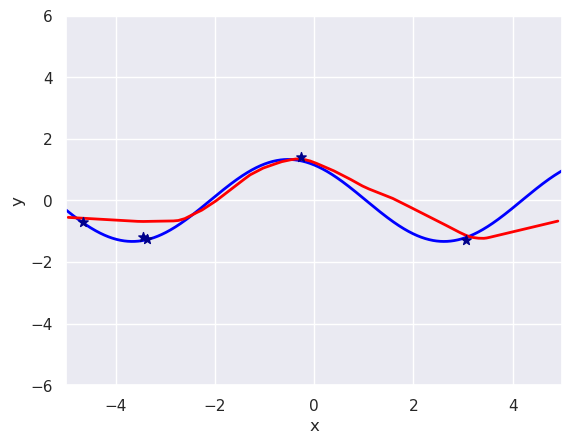

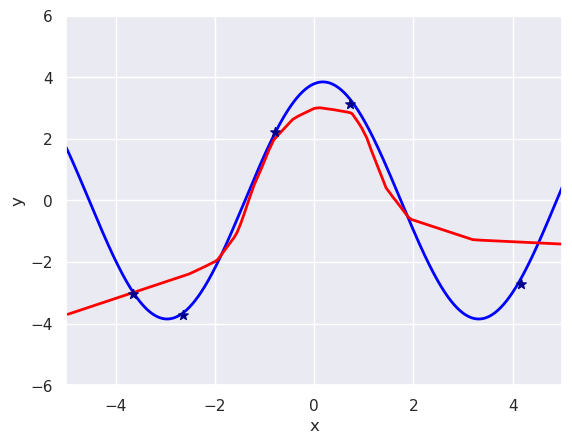

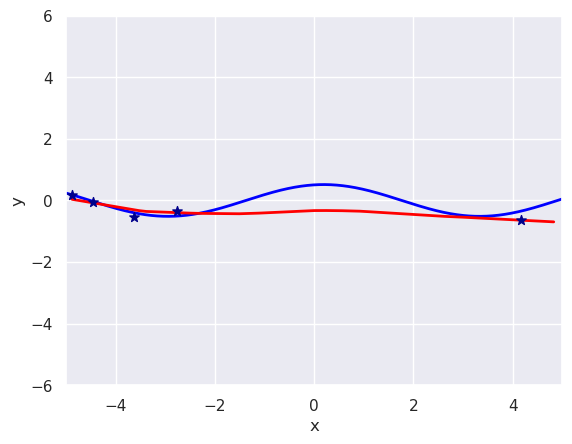

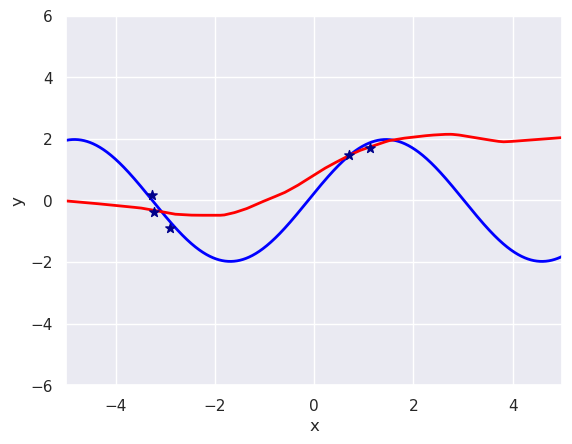

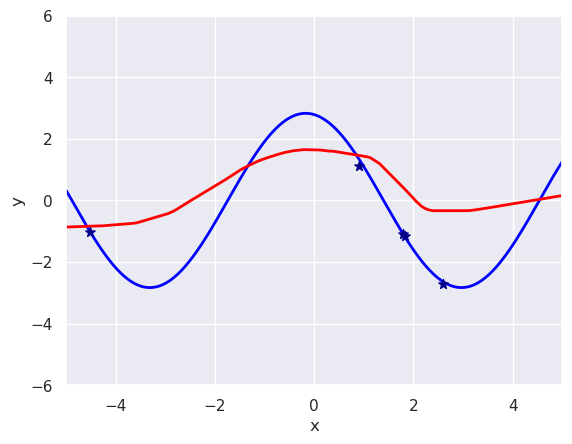

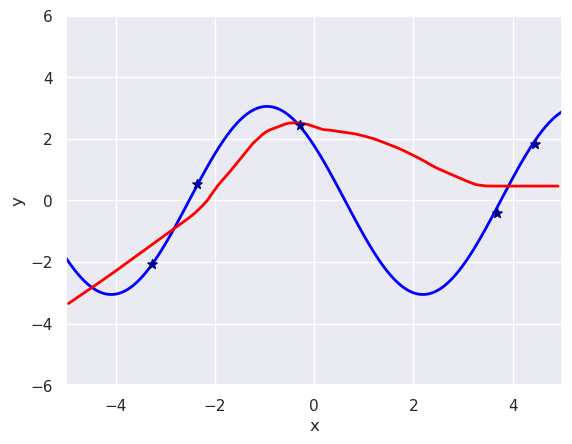

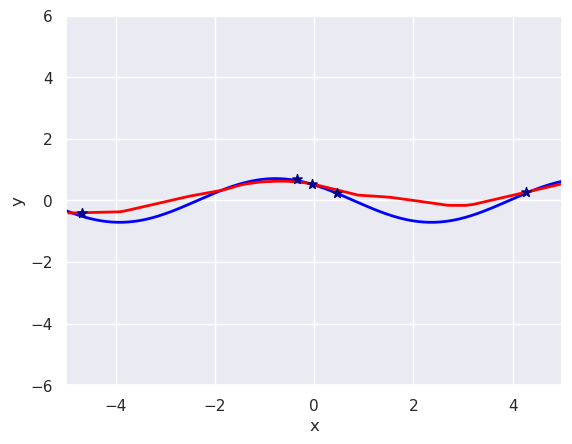

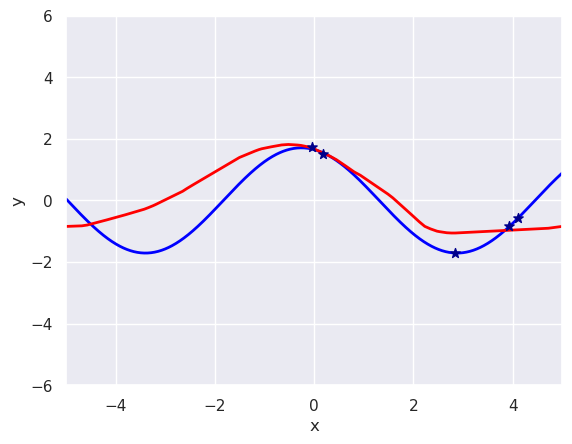

In [18]:
# fine tuning
import higher
import copy

net.train()
for param in net.parameters():
    param.requires_grad = True
    
sample_size = 200
n_ft = 20 # number of fine-tuning steps


for i in range(10):
    sample_task = tasks_test.sample_task()
    x_all, y_all = sample_task.sample_data(sample_size, noise=0.1, sort=True)
    indices = np.arange(sample_size)
    np.random.shuffle(indices)
    query_indices = np.sort(indices[n_shot_test:])
    support_indices = np.sort(indices[0:n_shot_test])
    x_support = x_all[support_indices]
    y_support = y_all[support_indices]
    x_query = x_all[query_indices]
    y_query = y_all[query_indices]


    # Create a new model instance and load the original model's state
    ft_net = Feature()
    ft_net.load_state_dict(copy.deepcopy(net.state_dict()))  # Deep copy the original model's weights

    # Set up an optimizer for fine-tuning
    optimizer = optim.Adam(ft_net.parameters(), lr=0)  # lr=0 because we manually apply updates

    # Fine-tuning loop
    for _ in range(n_ft):
        # Forward pass
        train_logit = ft_net(x_support).reshape(-1)
        inner_loss = F.mse_loss(train_logit, y_support)

        # Backward pass
        inner_loss.backward()

        # Manually update each parameter using the custom learning rates
        with torch.no_grad():
            for name, param in ft_net.named_parameters():
                if name in Sigma_adapted_lr:
                    if param.grad is not None:
                        param_update = Sigma_adapted_lr[name] * param.grad
                        param -= param_update
                    else:
                        print(f"Warning: Gradient for {name} is None. Skipping update.")

        # Clear the gradients after the update
        optimizer.zero_grad()

    # After fine-tuning, you can evaluate on the query set
    with torch.no_grad():
        pred = ft_net(x_all)

    #Plot
    fig, ax = plt.subplots()
    #true-curve
    true_curve = np.linspace(train_range[0], train_range[1], 1000)
    true_curve = [sample_task.true_function(x) for x in true_curve]
    ax.plot(np.linspace(train_range[0], train_range[1], 1000), true_curve, color='blue', linewidth=2.0)
    if(train_range[1]<test_range[1]):
        dotted_curve = np.linspace(train_range[1], test_range[1], 1000)
        dotted_curve = [sample_task.true_function(x) for x in dotted_curve]
        ax.plot(np.linspace(train_range[1], test_range[1], 1000), dotted_curve, color='blue', linestyle="--", linewidth=2.0)
    #query points (ground-truth)
    #ax.scatter(x_query, y_query, color='blue')
    #query points (predicted)

    ax.plot(np.squeeze(x_all), pred.detach().numpy(), color='red', linewidth=2.0)
    #support points
    ax.scatter(x_support.detach(), y_support.detach(), color='darkblue', marker='*', s=50, zorder=10)

    #all points
    #ax.scatter(x_all.numpy(), y_all.numpy())
    #plt.show()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.ylim(-6.0, 6.0)
    plt.xlim(test_range[0], test_range[1])
    plt.savefig('plot_oursIX_multi_finetuned_' + str(i) + '.png', dpi=300)

In [19]:
np.random.seed(3)
torch.manual_seed(3)

print("Test, please wait...")

net.train()
n_ft = 20
tot_iterations=500
sample_size = 200

mse_list = list()

for epoch in range(tot_iterations):
    sample_task = tasks_test.sample_task()
    x_all, y_all = sample_task.sample_data(sample_size, noise=0.1, sort=True)
    indices = np.arange(sample_size)
    np.random.shuffle(indices)
    support_indices = np.sort(indices[0:n_shot_test])

    query_indices = np.sort(indices[n_shot_test:])
    x_support = x_all[support_indices]
    y_support = y_all[support_indices]
    x_query = x_all[query_indices]
    y_query = y_all[query_indices]

    # Create a new model instance and load the original model's state
    ft_net = Feature()
    ft_net.load_state_dict(copy.deepcopy(net.state_dict()))  # Deep copy the original model's weights

    # Set up an optimizer for fine-tuning
    optimizer = optim.Adam(ft_net.parameters(), lr=0)  # lr=0 because we manually apply updates

    # Fine-tuning loop
    for _ in range(n_ft):
        # Forward pass
        train_logit = ft_net(x_support).reshape(-1)
        inner_loss = F.mse_loss(train_logit, y_support)

        # Backward pass
        inner_loss.backward()

        # Manually update each parameter using the custom learning rates
        with torch.no_grad():
            for name, param in ft_net.named_parameters():
                if name in Sigma_adapted_lr:
                    if param.grad is not None:
                        param_update = Sigma_adapted_lr[name] * param.grad
                        param -= param_update
                    else:
                        print(f"Warning: Gradient for {name} is None. Skipping update.")

        # Clear the gradients after the update
        optimizer.zero_grad()

    # After fine-tuning, you can evaluate on the query set
    with torch.no_grad():
        pred = ft_net(x_query).reshape(-1)
        
    mse = criterion(pred, y_query)
    mse_list.append(mse.item())

print("-------------------")
print("Average MSE: " + str(np.mean(mse_list)) + " +- " + str(np.std(mse_list)))
print("-------------------")

Test, please wait...
-------------------
Average MSE: nan +- nan
-------------------


# Optimization-based updates

In [ ]:
net.train()
optimizer = torch.optim.Adam([{'params': net.parameters(), 'lr': 1e-2}])
sample_size = 200
n_ft = 50 # number of fine-tuning steps


for i in range(10):
    sample_task = tasks_test.sample_task()
    x_all, y_all = sample_task.sample_data(sample_size, noise=0.1, sort=True)
    indices = np.arange(sample_size)
    np.random.shuffle(indices)
    query_indices = np.sort(indices[n_shot_test:])
    support_indices = np.sort(indices[0:n_shot_test])
    x_support = x_all[support_indices]
    y_support = y_all[support_indices]
    x_query = x_all[query_indices]
    y_query = y_all[query_indices]


    with higher.innerloop_ctx(net, optimizer, track_higher_grads=False) as (fmodel, opt):
        # Fine tuning
        for _ in range(n_ft):
            train_logit = fmodel(x_support).reshape(-1)
            inner_loss = F.mse_loss(train_logit, y_support)
            opt.step(inner_loss)
            
        #Evaluation on all data
        pred = fmodel(x_all)

        #Plot
        fig, ax = plt.subplots()
        #true-curve
        true_curve = np.linspace(train_range[0], train_range[1], 1000)
        true_curve = [sample_task.true_function(x) for x in true_curve]
        ax.plot(np.linspace(train_range[0], train_range[1], 1000), true_curve, color='blue', linewidth=2.0)
        if(train_range[1]<test_range[1]):
            dotted_curve = np.linspace(train_range[1], test_range[1], 1000)
            dotted_curve = [sample_task.true_function(x) for x in dotted_curve]
            ax.plot(np.linspace(train_range[1], test_range[1], 1000), dotted_curve, color='blue', linestyle="--", linewidth=2.0)
        #query points (ground-truth)
        #ax.scatter(x_query, y_query, color='blue')
        #query points (predicted)

        ax.plot(np.squeeze(x_all), pred.detach().numpy(), color='red', linewidth=2.0)
        #support points
        ax.scatter(x_support.detach(), y_support.detach(), color='darkblue', marker='*', s=50, zorder=10)

        #all points
        #ax.scatter(x_all.numpy(), y_all.numpy())
        #plt.show()
        plt.ylim(-6.0, 6.0)
        plt.xlim(test_range[0], test_range[1])
        #plt.savefig('plot_DKT_' + str(i) + '.png', dpi=300)

## Sketching FIM

In [13]:
for param in net.parameters():
    param.requires_grad_(False)

In [14]:
def low_rank_approx(Y, W, Psi):
    """
    given Y = A @ Om, (N, k)
    and W = Psi @ A, (l, M)
    and Psi(X) = Psi @ X, (N,...) -> (l,...)
    where Om and Psi and random sketching operators
    returns Q (N x k), X (k x M) such that A ~= QX
    """
    # Perform QR decomposition on Y to get orthonormal basis Q
    Q, _ = torch.linalg.qr(Y, mode='reduced')
    
    # Apply Psi to Q and then perform QR decomposition
    U, T = torch.linalg.qr(torch.matmul(Psi, Q), mode='reduced')
    
    # Solve the triangular system T @ X = U^T @ W for X
    # PyTorch does not have a direct equivalent to scipy.linalg.solve_triangular,
    # so we use torch.linalg.solve which can handle triangular matrices if specified.
    X = torch.linalg.solve(T, torch.matmul(U.T, W))
    
    return Q, X


In [15]:
def sym_low_rank_approx(Y, W, Psi):
    """
    Perform a symmetric low-rank approximation of the matrix A.
    """
    Q, X = low_rank_approx(Y, W, Psi)  # Assuming Psi is now correctly handled
    k = Q.shape[-1]  # Dimension of the sketches
    
    # Concatenate Q and X.T along columns to form a larger matrix
    tmp = torch.cat((Q, X.T), dim=1)  # Correctly access the transpose
    
    # Perform QR decomposition on the concatenated matrix
    U, T = torch.linalg.qr(tmp, mode='reduced')
    
    # Extract T1 and T2 from T
    T1 = T[:, :k]
    T2 = T[:, k:2*k]
    
    # Compute symmetric matrix S
    S = (T1 @ T2.T + T2 @ T1.T) / 2
    
    return U, S

# Example usage
N, k, l = 100, 10, 50  # Example dimensions
Y = torch.randn(N, k)  # Random Y matrix
W = torch.randn(l, N)  # Random W matrix
Psi = torch.randn(l, N)  # Random Psi matrix

# Call the function
U, S = sym_low_rank_approx(Y, W, Psi)

In [16]:
def fixed_rank_eig_approx(Y, W, psi, r):
    """
    Returns U (N x r), D (r) such that A ~= U diag(D) U^T using PyTorch.
    """
    # Obtain symmetric low-rank approximation
    U, S = sym_low_rank_approx(Y, W, psi)
    
    # Compute eigenvalues and eigenvectors
    D, V = torch.linalg.eigh(S)
    
    # Truncate to keep the top-r eigenvalues and corresponding eigenvectors
    D = D[-r:]  # Top r eigenvalues
    V = V[:, -r:]  # Corresponding eigenvectors
    
    # Update U to be U @ V
    U = U @ V
    
    return U, D

# Example usage
N, k, l, r = 100, 10, 50, 5  # Example dimensions
Y = torch.randn(N, k)  # Random Y matrix
W = torch.randn(l, N)  # Random W matrix
Psi = torch.randn(l, N)  # Random Psi matrix

# Call the function
U, D = fixed_rank_eig_approx(Y, W, Psi, r)

In [17]:
def sketch(net, batches, k, l):
    """
    Returns a good rank 2k approximation of the FIM using PyTorch.
    """
    M = batches.size(0)
    N_params = sum(p.numel() for p in net.parameters())
    print(N_params)

    om = torch.randn(k, N_params)
    psi = torch.randn(l, N_params)

    Y = torch.zeros(N_params, k)
    W = torch.zeros(l, N_params)

    for batch in batches:
        JT = jacobian(net, batch).T
        Y += (om @ JT @ JT.T).T / M
        W += (psi @ JT @ JT.T) / M

    # Compute the rank-2k approximation
    U, D = fixed_rank_eig_approx(Y, W, psi, 2 * k)

    return U, D

def jacobian(net, batch):
    """
    Compute the Jacobian for the batch. This needs to be adapted based on the actual function.
    """
    net.zero_grad()
    params = {k: v for k, v in net.named_parameters()}
    def fnet_single(params, x):
        return functional_call(net, params, (x.unsqueeze(0),)).squeeze(0)
        
    jac = vmap(jacrev(fnet_single), (None, 0))(params, batch)
    jac = jac.values()
    # jac1 of dimensions [Nb Layers, Nb input / Batch, dim(y), Nb param/layer left, Nb param/layer right]
    reshaped_tensors = [
        j.flatten(2)                # Flatten starting from the 3rd dimension to acount for weights and biases layers
            .permute(2, 0, 1)         # Permute to align dimensions correctly for reshaping
            .reshape(-1, j.shape[0] * j.shape[1])  # Reshape to (c, a*b) using dynamic sizing
        for j in jac
    ]
    return torch.cat(reshaped_tensors, dim=0)

# Example usage would require setting up a model, parameters, batches, etc.

In [18]:
import time

def proj_sketch(net, batches, subspace_dimension):
    t = time.time_ns()

    T = 6 * subspace_dimension + 4 
    k = (T - 1) // 3                    # k = 2 * subspace_dimension + 1
    l = T - k                           # l = 4 * subspace_dimension + 3

    U, D = sketch(net, batches, k, l)
    idx = D.argsort(descending=True)
    print("U shape:", U.shape)
    print("Index tensor:", idx)
    print("Requested subspace dimension:", subspace_dimension)
    
    # Ensure idx is of type long for indexing
    # idx = idx.long()

    P1 = U[:, idx[:subspace_dimension]].T

    print(f"Done sketching in {(time.time_ns() - t) / 1e9:.4f} s")

    return P1

In [19]:
subspace_dimension = 10

print("Finding projection matrix")
# here we use the exact FIM, we do not need to approximate given the (small) size of the network
# P1 = fim.proj_exact(key=key_fim, apply_fn=apply_fn, current_params=pre_state.params, current_batch_stats=pre_state.batch_stats, subspace_dimension=subspace_dimension)


# Generate batches in the range [-5, 5]
batch_size = 100
input_dimensions = sum(p.numel() for p in net.parameters())
batches = 10 * torch.rand(batch_size, input_dimensions, 1) - 5  # Scaled from [0, 1] to [-5, 5]

# Call the projection sketch function
P1 = proj_sketch(net=net, batches=batches, subspace_dimension=subspace_dimension)

# Still part of the computation graph ; detach it :
P1 = P1.detach()
print(f"PROJECTION MATRIX : {P1}")
print("Found projection matrix")

Finding projection matrix
1761
U shape: torch.Size([1761, 42])
Index tensor: tensor([41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24,
        23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10,  9,  8,  7,  6,
         5,  4,  3,  2,  1,  0])
Requested subspace dimension: 10
Done sketching in 50.6237 s
PROJECTION MATRIX : tensor([[-0.0237, -0.0232, -0.0237,  ..., -0.0237, -0.0238, -0.0238],
        [ 0.0149,  0.0503,  0.0028,  ...,  0.0585,  0.0166, -0.0407],
        [ 0.0259, -0.0021,  0.0021,  ..., -0.0231, -0.0057,  0.0301],
        ...,
        [ 0.0123,  0.0231,  0.0007,  ...,  0.0215,  0.0308, -0.0049],
        [-0.0071,  0.0002, -0.0059,  ...,  0.0111, -0.0076, -0.0056],
        [ 0.0168,  0.0235,  0.0104,  ...,  0.0112,  0.0201, -0.0227]])
Found projection matrix


## Unlimitd F

In [20]:
class NTKernel_proj(gpytorch.kernels.Kernel):
    def __init__(self, net, subspace_dimension, P1, **kwargs):
        super(NTKernel_proj, self).__init__(**kwargs)
        self.net = net
        self.sub_dim = subspace_dimension
        self.P1 = P1 # Projection matrix
        
        # Add 10 scaling parameters, initializing them as one
        self.scaling_param = nn.Parameter(torch.ones(subspace_dimension))

    def forward(self, x1, x2, diag=False, **params):
        jac1 = self.compute_jacobian(x1)
        jac2 = self.compute_jacobian(x2) if x1 is not x2 else jac1
        D = torch.diag(torch.pow(self.scaling_param, 2))
        
        # print("jac1.T shape:", jac1.T.shape)
        # print("P1 shape:", P1.T.shape)
        # print("D shape:", D.shape)
        # print("P1.T shape:", P1.shape)
        # print("jac2 shape:", jac2.shape)
        
        result = torch.chain_matmul(jac1, P1.T, D, P1, jac2.T)
        
        if diag:
            return result.diag()
        return result
    
    def compute_jacobian(self, inputs):
        """
        Return the jacobian of a batch of inputs, thanks to the vmap functionality
        """
        self.zero_grad()
        params = {k: v for k, v in self.net.named_parameters()}
        def fnet_single(params, x):
            return functional_call(net, params, (x.unsqueeze(0),)).squeeze(0)
        
        jac = vmap(jacrev(fnet_single), (None, 0))(params, inputs)
        jac = jac.values()
        # jac1 of dimensions [Nb Layers, Nb input / Batch, dim(y), Nb param/layer left, Nb param/layer right]
        reshaped_tensors = [
            j.flatten(2)                # Flatten starting from the 3rd dimension to acount for weights and biases layers
                .permute(2, 0, 1)         # Permute to align dimensions correctly for reshaping
                .reshape(-1, j.shape[0] * j.shape[1])  # Reshape to (c, a*b) using dynamic sizing
            for j in jac
        ]
        return torch.cat(reshaped_tensors, dim=0).T

In [21]:
class CosSimNTKernel_proj(gpytorch.kernels.Kernel):
    def __init__(self, net, subspace_dimension, P1, **kwargs):
        super(CosSimNTKernel_proj, self).__init__(**kwargs)
        self.net = net
        
        self.alpha = nn.Parameter(torch.ones(1))
        
        self.sub_dim = subspace_dimension
        self.P1 = P1 # Projection matrix
        
        # Add 10 scaling parameters, initializing them as one
        self.scaling_param = nn.Parameter(torch.ones(subspace_dimension))

    def forward(self, x1, x2, diag=False, **params):
        jac1 = self.compute_jacobian(x1)
        jac2 = self.compute_jacobian(x2) if x1 is not x2 else jac1
        
        D = torch.diag(self.scaling_param)
        
        result_1 = torch.chain_matmul(D, P1, jac1.T)
        result_2 = torch.chain_matmul(D, P1, jac2.T)
        
        result_1_norm = result_1.norm(dim=0, keepdim=True)
        result_1_normalized = result_1/result_1_norm
        #print(result_1.shape)
        #print(result_1.norm(dim=0, keepdim=True).shape)
        result_2_norm = result_2.norm(dim=0, keepdim=True)
        result_2_normalized = result_2/result_2_norm
        
        result = self.alpha * result_1_normalized.T@result_2_normalized
        
        if diag:
            return result.diag()
        return result
    
    def compute_jacobian(self, inputs):
        """
        Return the jacobian of a batch of inputs, thanks to the vmap functionality
        """
        self.zero_grad()
        params = {k: v for k, v in self.net.named_parameters()}
        def fnet_single(params, x):
            return functional_call(net, params, (x.unsqueeze(0),)).squeeze(0)
        
        jac = vmap(jacrev(fnet_single), (None, 0))(params, inputs)
        jac = jac.values()
        # jac1 of dimensions [Nb Layers, Nb input / Batch, dim(y), Nb param/layer left, Nb param/layer right]
        reshaped_tensors = [
            j.flatten(2)                # Flatten starting from the 3rd dimension to acount for weights and biases layers
                .permute(2, 0, 1)         # Permute to align dimensions correctly for reshaping
                .reshape(-1, j.shape[0] * j.shape[1])  # Reshape to (c, a*b) using dynamic sizing
            for j in jac
        ]
        return torch.cat(reshaped_tensors, dim=0).T

In [22]:
class ExactGPModel_proj(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, net, subspace_dimension, P1):
        super(ExactGPModel_proj, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = NTKernel_proj(net, subspace_dimension, P1)
        #self.covar_module = CosSimNTKernel_proj(net, subspace_dimension, P1)
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5))
        #self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=4, ard_num_dims=40)
        #self.feature_extractor = feature_extractor
        
    def forward(self, x):
        #z = self.feature_extractor(x)
        #z_normalized = z - z.min(0)[0]
        #z_normalized = 2 * (z_normalized / z_normalized.max(0)[0]) - 1
        #x_normalized = x - x.min(0)[0]
        #x_normalized = 2 * (x_normalized / x_normalized.max(0)[0]) - 1
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [23]:
n_shot_train = 10
n_shot_test = 5
train_range=(-5.0, 5.0)
test_range=(-5.0, 5.0) # This must be (-5, +10) for the out-of-range condition
criterion = nn.MSELoss()
tasks     = Task_Distribution(amplitude_min=0.1, amplitude_max=5.0, 
                                  phase_min=0.0, phase_max=np.pi, 
                                  x_min=train_range[0], x_max=train_range[1], 
                                  family="sine")

net.train()
for param in net.parameters():
    param.requires_grad_(True)

likelihood.train()
# likelihood.noise_covar.register_constraint("raw_noise", gpytorch.constraints.GreaterThan(1e-4))
# likelihood.noise = 1e-4
dummy_inputs = torch.zeros([n_shot_train,1])
dummy_labels = torch.zeros([n_shot_train])
gp = ExactGPModel_proj(dummy_inputs, dummy_labels, likelihood, net, subspace_dimension, P1)
trainable_params = sum(p.numel() for p in gp.parameters() if p.requires_grad)
print(trainable_params)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp)
optimizer = torch.optim.Adam([{'params': gp.parameters(), 'lr': 1e-3}])

1772


In [24]:
tot_iterations=50000
for epoch in range(tot_iterations):
    # gp.likelihood.noise = 1e-2
    optimizer.zero_grad()
    inputs, labels = tasks.sample_task().sample_data(n_shot_train, noise=0.05)
    
    gp.set_train_data(inputs=inputs, targets=labels - net(inputs).reshape(-1))  
    predictions = gp(inputs)
    loss = -mll(predictions, gp.train_targets)
    loss.backward()
    optimizer.step()
    #---- print some stuff ----
    if(epoch%1000==0):
        mse = criterion(predictions.mean, labels)
        print(predictions.mean)
        print('[%d] - Loss: %.3f  MSE: %.3f  lengthscale: %.3f   noise: %.3f' % (
            epoch, loss.item(), mse.item(),
            0.0, #gp.covar_module.base_kernel.lengthscale.item(),
            gp.likelihood.noise.item()
        ))

/state/partition1/llgrid/pkg/anaconda/anaconda3-2023a-pytorch/lib/python3.9/site-packages/torch/functional.py:1626: UserWarning: torch.chain_matmul is deprecated and will be removed in a future PyTorch release. Use torch.linalg.multi_dot instead, which accepts a list of two or more tensors rather than multiple parameters. (Triggered internally at ../aten/src/ATen/native/LinearAlgebra.cpp:1079.)
  return _VF.chain_matmul(matrices)  # type: ignore[attr-defined]


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
[0] - Loss: 46.275  MSE: 2.765  lengthscale: 0.000   noise: 0.003
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
[1000] - Loss: 7.770  MSE: 14.298  lengthscale: 0.000   noise: 0.004
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
[2000] - Loss: 3.357  MSE: 8.680  lengthscale: 0.000   noise: 0.005
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
[3000] - Loss: 1.309  MSE: 1.470  lengthscale: 0.000   noise: 0.007
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
[4000] - Loss: 2.673  MSE: 8.840  lengthscale: 0.000   noise: 0.008
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
[5000] - Loss: 0.514  MSE: 2.797  lengthscale: 0.000   noise: 0.009
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
[6000] - Loss: 0.493  MSE: 3.828  lengthscale: 0.000   noise: 0.009
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
[7000] - Loss: 0.413  MSE: 1.702  lengthscale: 0.000   noise: 0.008
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
[8000] - Loss: -

## Second Test Phase

In [25]:
tasks_test = Task_Distribution(amplitude_min=0.1, amplitude_max=5.0, 
                                phase_min=0.0, phase_max=np.pi, 
                                x_min=test_range[0], x_max=test_range[1], 
                                family="sine")

sample_task = tasks_test.sample_task()

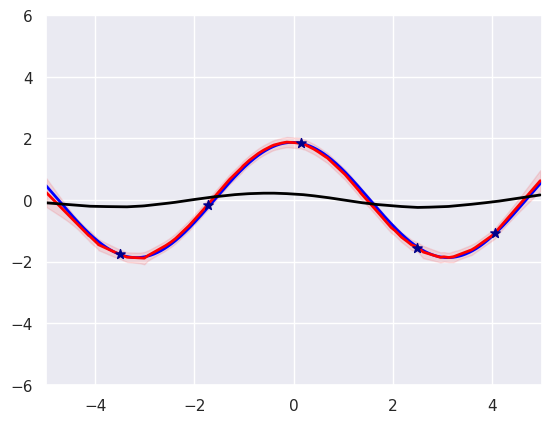

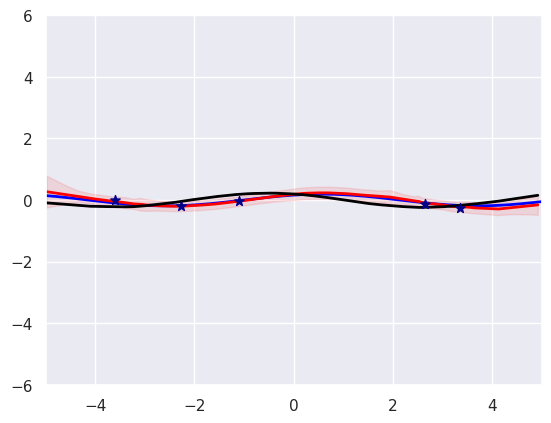

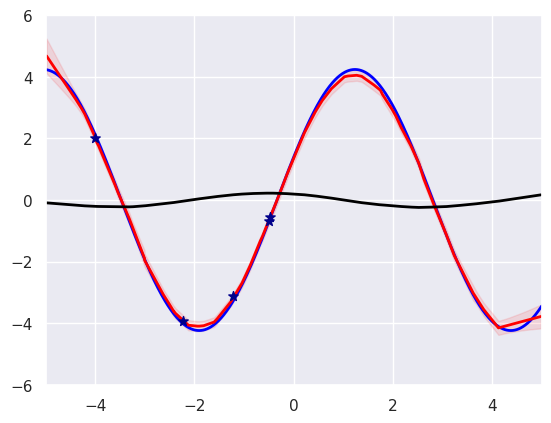

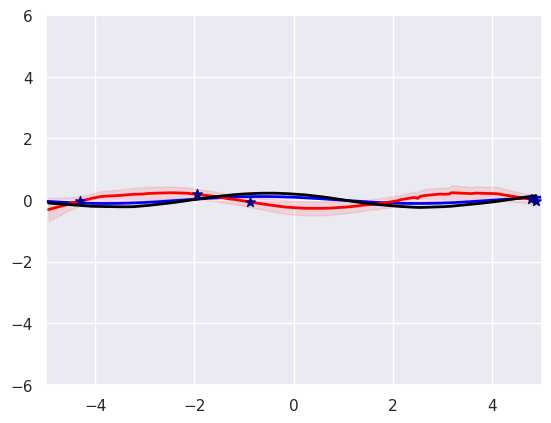

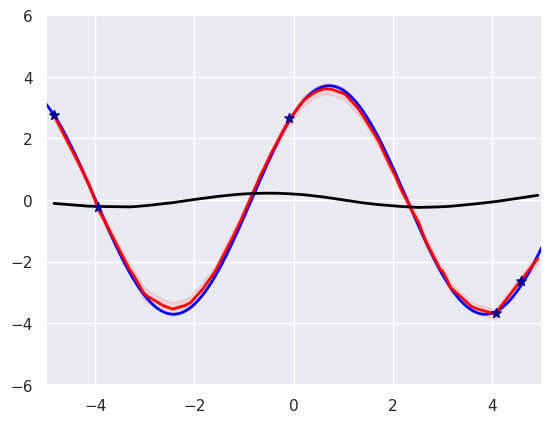

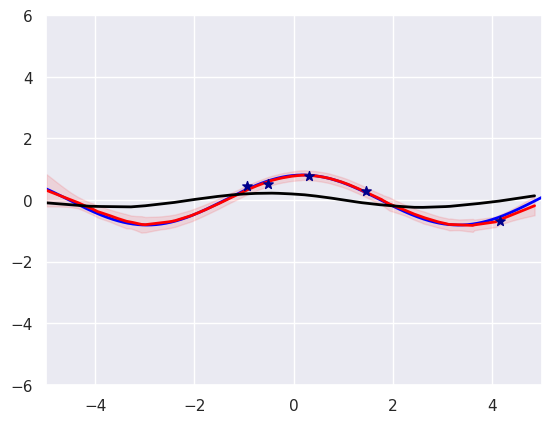

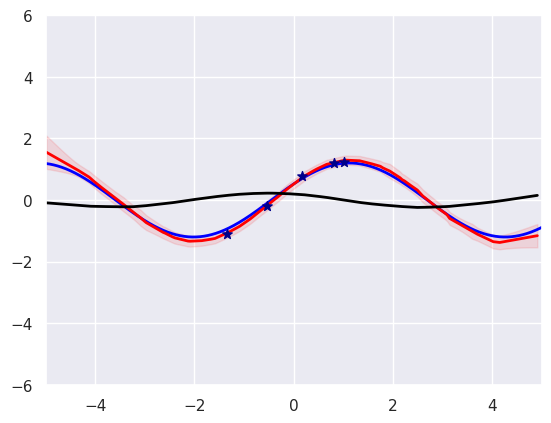

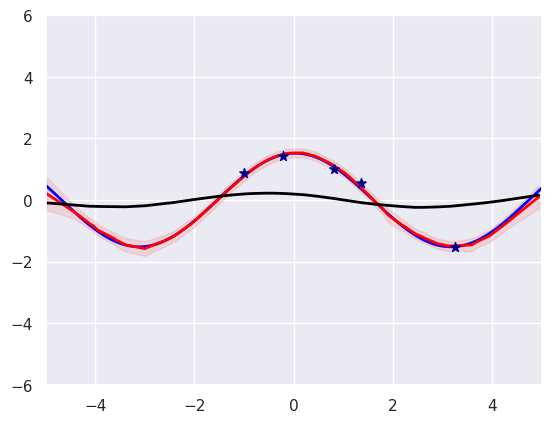

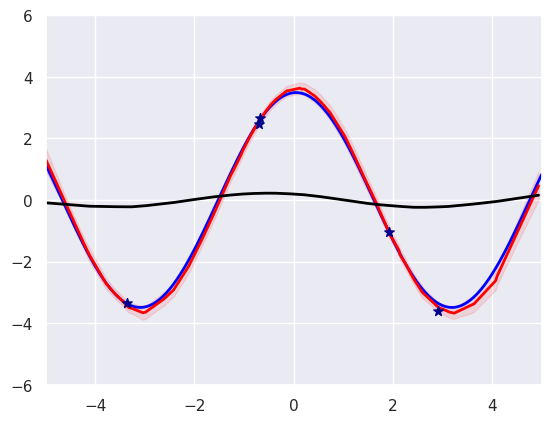

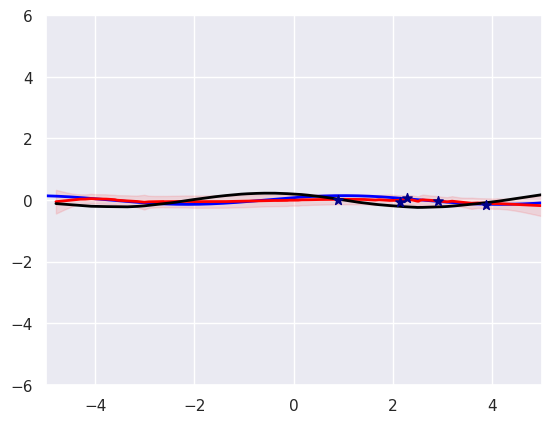

In [26]:
sample_size = 200

likelihood.eval()
net.eval()
gp.covar_module.eval()
# for param in net.parameters():
#     param.requires_grad_(False)
    
for i in range(10):
    sample_task = tasks_test.sample_task()
    x_all, y_all = sample_task.sample_data(sample_size, noise=0.1, sort=True)
    indices = np.arange(sample_size)
    np.random.shuffle(indices)
    query_indices = np.sort(indices[n_shot_test:])
    support_indices = np.sort(indices[0:n_shot_test])
    x_support = x_all[support_indices]
    y_support = y_all[support_indices]
    x_query = x_all[query_indices]
    y_query = y_all[query_indices]

    gp.train()
    gp.set_train_data(inputs=x_support, targets=y_support - net(x_support).reshape(-1), strict=False)  
    gp.eval()
            
    #Evaluation on all data
    mean = likelihood(gp(x_all)).mean + net(x_all).reshape(-1)
    lower, upper = likelihood(gp(x_all)).confidence_region() #2 standard deviations above and below the mean
    lower += net(x_all).reshape(-1)
    upper += net(x_all).reshape(-1)    
    
    #Plot
    fig, ax = plt.subplots()
    #true-curve
    true_curve = np.linspace(train_range[0], train_range[1], 1000)
    true_curve = [sample_task.true_function(x) for x in true_curve]
    ax.plot(np.linspace(train_range[0], train_range[1], 1000), true_curve, color='blue', linewidth=2.0)
    if(train_range[1]<test_range[1]):
        dotted_curve = np.linspace(train_range[1], test_range[1], 1000)
        dotted_curve = [sample_task.true_function(x) for x in dotted_curve]
        ax.plot(np.linspace(train_range[1], test_range[1], 1000), dotted_curve, color='blue', linestyle="--", linewidth=2.0)
    #query points (ground-truth)
    #ax.scatter(x_query, y_query, color='blue')
    #query points (predicted)

    ax.plot(np.squeeze(x_all), mean.detach().numpy(), color='red', linewidth=2.0)
    ax.plot(np.squeeze(x_all), net(x_all).reshape(-1).detach().numpy(), color='black', linewidth=2.0)
    ax.fill_between(np.squeeze(x_all),
                    lower.detach().numpy(), upper.detach().numpy(),
                    alpha=.1, color='red')
    #support points
    ax.scatter(x_support, y_support, color='darkblue', marker='*', s=50, zorder=10)
                    
    #all points
    #ax.scatter(x_all.numpy(), y_all.numpy())
    #plt.show()
    plt.ylim(-6.0, 6.0)
    plt.xlim(test_range[0], test_range[1])
    #plt.savefig('plot_DKT_' + str(i) + '.png', dpi=300)

In [27]:
print("Test, please wait...")

likelihood.eval()
net.eval()
tot_iterations=500
mse_list = list()
for epoch in range(tot_iterations):
    sample_task = tasks_test.sample_task()
    sample_size = 200
    x_all, y_all = sample_task.sample_data(sample_size, noise=0.1, sort=True)
    indices = np.arange(sample_size)
    np.random.shuffle(indices)
    support_indices = np.sort(indices[0:n_shot_test])

    query_indices = np.sort(indices[n_shot_test:])
    x_support = x_all[support_indices]
    y_support = y_all[support_indices]
    x_query = x_all[query_indices]
    y_query = y_all[query_indices]

    #Feed the support set
    gp.train()
    gp.set_train_data(inputs=x_support, targets=y_support - net(x_support).reshape(-1), strict=False)  
    gp.eval()

    #Evaluation on query set
    mean = likelihood(gp(x_query)).mean + net(x_query).reshape(-1)

    mse = criterion(mean, y_query)
    mse_list.append(mse.item())

print("-------------------")
print("Average MSE: " + str(np.mean(mse_list)) + " +- " + str(np.std(mse_list)))
print("-------------------")

Test, please wait...
-------------------
Average MSE: 0.022219750188291074 +- 0.013551268869610408
-------------------


In [28]:
print(gp.covar_module.scaling_param)

Parameter containing:
tensor([-1.9633e-07, -9.2728e-19,  9.6671e-02, -3.1859e-25, -3.5317e-14,
         8.1733e+00,  2.7366e-01,  5.0820e+00,  5.5501e+00,  8.3923e-02],
       requires_grad=True)


## Other STUFF

In [291]:
# Hyperparams
num_epochs = 50
n_tasks_per_epoch = 10
input_dim = 1
K = 10 # Number of points per task
data_noise = 0.05
# Covariance noise already leant via gpytorch.likelihoods.GaussianLikelihood()

# Define model, likelihood, and optimizer
model = NNwithGP(40, K, 'relu', 10)
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
], lr=0.01)

# Training_loop
model.train()
model.likelihood.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # Get a new batch of data
    train_x, train_y = get_raw_batch(n_tasks_per_epoch, K, 0, data_noise)
    
    # Initialize loss accumulation
    total_loss = 0
    
    # Loop over each task
    for i in range(train_x.size(0)):  # Assuming train_x is of shape (nb_task, K, 1)
        # Process each task individually
        nn_output = model.forward_nn(train_x[i])  # Forward pass through the NN for task i
        gp_pred = model.forward_gp(nn_output)  # GP forward using NN output for task i
        loss = -model.likelihood(gp_pred, train_y[i]).log_prob(train_y[i])  # Compute NLL for task i
        total_loss += loss  # Accumulate loss

    # Calculate mean loss across all tasks
    mean_loss = total_loss / n_tasks_per_epoch
    
    # Backpropagate the mean loss
    mean_loss.backward()
    
    # Optimization step
    optimizer.step()
    
    # Print the average loss for this epoch
    print(f'Epoch {epoch+1}, Mean Loss: {mean_loss.item()}')

NameError: name 'NNwithGP' is not defined

In [8]:
class NNwithGP(nn.Module):
    def __init__(self, n_neurons, K, activation, reg_dim):
        super(NNwithGP, self).__init__()
        # Neural network layers
        self.dense1 = nn.Linear(K, n_neurons)
        if activation == "relu":
            self.act_fn = nn.ReLU()
        elif activation == "tanh":
            self.act_fn = nn.Tanh()
        self.dense2 = nn.Linear(n_neurons, n_neurons)
        self.dense3 = nn.Linear(n_neurons, reg_dim)

        # Additional parameter used in the GP kernel
        self.extra_param = nn.Parameter(torch.randn(1))

        # GP Model Components
        self.gp_mean = gpytorch.means.ConstantMean()
        self.gp_covar = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.likelihood = gpytorch.likelihoods.GaussianLikelihood()

    def forward_nn(self, x):
        x = self.act_fn(self.dense1(x))
        x = self.act_fn(self.dense2(x))
        x = self.dense3(x)
        return x

    def forward_gp(self, x):
        mean_x = self.gp_mean(x)
        # Use extra_param in the kernel
        self.gp_covar.base_kernel.lengthscale = torch.abs(self.extra_param)
        covar_x = self.gp_covar(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [5]:
import torch
import torch.nn as nn

# Define a simple neural network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(2, 40)
        self.layer2 = nn.Linear(40,40)
        self.layer3 = nn.Linear(40,1)
        
    def forward(self, x):
        out = F.relu(self.layer1(x))
        out = F.relu(self.layer2(out))
        out = self.layer3(out)
        return out

# Initialize the network
model = SimpleNN()

# Define an input tensor
input_tensor = torch.randn(2, 1, requires_grad=True)

# Forward pass
outputs = model(input_tensor)

# Initialize the Jacobian matrix
jacobian = torch.zeros(len(outputs.flatten()), sum(p.numel() for p in model.parameters()))

# Compute Jacobian
for i, output in enumerate(outputs.flatten()):
    # Zero all parameter gradients
    model.zero_grad()
    # Compute gradient of output[i] with respect to all parameters
    output.backward(retain_graph=True)
    # Store gradients in the Jacobian row
    j = 0
    for param in model.parameters():
        jacobian[i, j:j+param.numel()] = param.grad.flatten()
        j += param.numel()

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)

print("Trainable parameters:", trainable_params)
print("Non-trainable parameters:", non_trainable_params)
print("Jacobian matrix:")
print(jacobian.shape)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x1 and 2x40)

In [11]:
from torch.func import functional_call, vmap, vjp, jvp, jacrev
device = 'cuda' if torch.cuda.device_count() > 0 else 'cpu'

x_train = torch.randn(20, 5, device=device)
x_test = torch.randn(20, 5, device=device)


net = SimpleNN().to(device)

# Detaching the parameters because we won't be calling Tensor.backward().
params = {k: v.detach() for k, v in net.named_parameters()}

def apply_net(params, x):
    return functional_call(net, params, (x.unsqueeze(0),)).squeeze(0)

def empirical_ntk_jacobian_contraction(fnet_single, params, x1, x2):
    # Compute J(x1)
    jac1 = torch.autograd.functional.jacobian(lambda params: apply_net(params, x1))
    print(jac1.shape)

    # Compute J(x2)
    jac2 = vmap(jacrev(fnet_single), (None, 0))(params, x2)
    jac2 = jac2.values()
    jac2 = [j.flatten(2) for j in jac2]
    print(jac1[1].shape)

    # Compute J(x1) @ J(x2).T
    result = torch.stack([torch.einsum('Nf,Mf->NM', j1, j2) for j1, j2 in zip(jac1, jac2)])
    result = result.sum(0)
    return result

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)

print("Trainable parameters:", trainable_params)
print("Non-trainable parameters:", non_trainable_params)
result = empirical_ntk_jacobian_contraction(fnet_single, params, x_train, x_train)
print(result.shape)

Trainable parameters: 1801
Non-trainable parameters: 0


TypeError: The inputs given to jacobian must be either a Tensor or a tuple of Tensors but the given inputs has type <class 'builtin_function_or_method'>.

In [43]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(10, 20)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(20, 1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [51]:
class NTKernel(gpytorch.kernels.Kernel):
    def __init__(self, net, **kwargs):
        super(NTKernel, self).__init__(**kwargs)
        self.net = net

    def compute_gradients(self, inputs):
        params = {k: v for k, v in self.net.named_parameters()}
        def fnet_single(params, x):
            return functional_call(net, params, (x.unsqueeze(0),)).squeeze(0)
        
        

    def forward(self, x1, x2, diag=False, **params):
        grads_x1 = self.compute_gradients(x1)
        grads_x2 = self.compute_gradients(x2) if x1 is not x2 else grads_x1
        result = torch.matmul(grads_x1, grads_x2.transpose(-1, -2))
        
        if diag:
            return result.diag()
        return result

# Make sure the network and the kernel are correctly initialized and used


In [52]:
class GPWithNTK(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, neural_net):
        super(GPWithNTK, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = NTKernel(neural_net)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [56]:
train_x = torch.randn(50, 10)  # Example data
train_y = torch.randn(50)  # Example targets

likelihood = gpytorch.likelihoods.GaussianLikelihood()
net = SimpleNN()
model = GPWithNTK(train_x, train_y, likelihood, net)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Training loop
model.train()
likelihood.train()
optimizer = torch.optim.Adam([
    {'params': model.parameters(), 'lr': 0.01}
], lr=0.1)

for i in range(50):
    optimizer.zero_grad()
    model.set_train_data(inputs=train_x, targets=train_y)  
    predictions = model(train_x)
    loss = -mll(predictions, model.train_targets)
    loss.backward()
    optimizer.step()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, 50, loss.item()))


RecursionError: maximum recursion depth exceeded while calling a Python object

In [269]:
import torch
import torch.nn as nn
from torch.func import functional_call, vmap, vjp, jvp, jacrev
device = 'cuda' if torch.cuda.device_count() > 0 else 'cpu'

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(1, 2)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(2, 4)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(4, 3)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [270]:
x_train = torch.randn(20, 1, device=device)
x_test = torch.randn(5, 1, device=device)

In [271]:
net = SimpleNN().to(device)

trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
non_trainable_params = sum(p.numel() for p in net.parameters() if not p.requires_grad)

print("Trainable parameters:", trainable_params)
print("Non-trainable parameters:", non_trainable_params)

params = {k: v for k, v in net.named_parameters()}
print(list(params.keys()))
print(params['fc1.weight'].shape)
print(params['fc1.bias'].shape)
print(params['fc2.weight'].shape)
print(params['fc2.bias'].shape)
print(params['fc3.weight'].shape)
print(params['fc3.bias'].shape)
def fnet_single(params, x):
    return functional_call(net, params, (x.unsqueeze(0),)).squeeze(0)

Trainable parameters: 31
Non-trainable parameters: 0
['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias']
torch.Size([2, 1])
torch.Size([2])
torch.Size([4, 2])
torch.Size([4])
torch.Size([3, 4])
torch.Size([3])


In [275]:
def empirical_ntk_jacobian_contraction(fnet_single, params, x1, x2):
    # Compute J(x1)
    jac1 = vmap(jacrev(fnet_single), (None, 0))(params, x1)
    print(jac1.keys())
    jac1 = jac1.values()
    # jac1 = [Nb Layers, Nb input / Batch, dim(y), Nb param/layer left, Nb param/layer right]
    def reshape_jac(jacobians):
        reshaped_tensors = [
            j.flatten(2)                # Flatten starting from the 3rd dimension to acount for weights and biases layers
              .permute(2, 0, 1)         # Permute to align dimensions correctly for reshaping
              .reshape(-1, j.shape[0] * j.shape[1])  # Reshape to (c, a*b) using dynamic sizing
            for j in jacobians
        ]
        return torch.cat(reshaped_tensors, dim=0)
    
    jac1 = reshape_jac(jac1)
    print(jac1.shape)

    # Compute J(x2)
    jac2 = vmap(jacrev(fnet_single), (None, 0))(params, x2)
    jac2 = jac2.values()
    jac2 = reshape_jac(jac2)
    print(jac2.shape)

    # Compute J(x1) @ J(x2).T
    result = torch.einsum('fN,fM->NM', jac1, jac2)
    return result

result = empirical_ntk_jacobian_contraction(fnet_single, params, x_train, x_test)
print(result.shape)

dict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])
torch.Size([31, 60])
torch.Size([31, 15])
torch.Size([60, 15])
